### 2023-05-30 coarsened-fine-clouds'-radiation

In [1]:
from string import ascii_lowercase
import cftime
import xarray as xr
import numpy as np
import dataclasses
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import fv3viz
from vcm.catalog import catalog as CATALOG
from vcm.fv3.metadata import standardize_fv3_diagnostics

In [2]:
RADIATION_RUNS = {
    'coarsened_fine_cloud': 'gs://vcm-ml-experiments/cloud-ml/2023-07-04/cloud-ml-prognostic-run-prescribed-cloud-cc-decorr/fv3gfs_run/radiative_fluxes.zarr',
    'baseline_coarse_nudged': 'gs://vcm-ml-experiments/cloud-ml/2023-07-03/cloud-ml-prognostic-run-nudge-to-fine-baseline/fv3gfs_run/radiative_fluxes.zarr'
}
C48_REFERENCE_KEY = '10day_c48_PIRE_ccnorm_gfsphysics_15min_may2023'
TIME_SLICE = slice(
    cftime.DatetimeJulian(2020, 8, 7, 0, 30, 0),
    cftime.DatetimeJulian(2020, 8, 10, 0, 30, 0),
    4
) # hourly over days 8-10 validation
OUTDIR = 'figures'
GRID = CATALOG['grid/c48'].read()
plt.rcParams.update({'font.size': 8})

In [3]:
@dataclasses.dataclass
class RadiationDiag:
    fortran_diag_name: str
    python_diag_name: str
    scale: float
    
FLUXES = [
    RadiationDiag('DSWRFsfc', 'total_sky_downward_shortwave_flux_at_surface', 100.0),
    RadiationDiag('DLWRFsfc', 'total_sky_downward_longwave_flux_at_surface', 30.0),
    RadiationDiag('USWRFtoa', 'total_sky_upward_shortwave_flux_at_top_of_atmosphere', 100.0),
    RadiationDiag('ULWRFtoa', 'total_sky_upward_longwave_flux_at_top_of_atmosphere', 30.0),
]

In [4]:
def get_coarsened_fine_fluxes():
    ds = CATALOG[C48_REFERENCE_KEY].to_dask()
    ds = _rename_fortran_fluxes(ds)
    return ds

def get_python_fluxes(path):
    print(path)
    ds = xr.open_zarr(path, consolidated=True)
    ds = _rename_python_fluxes(ds)
    return ds

def _rename_fortran_fluxes(ds):
    ds = standardize_fv3_diagnostics(ds)
    ds_rename = xr.Dataset()
    for diag in FLUXES:
        if diag.fortran_diag_name in ds:
            ds_rename[diag.python_diag_name] = ds[diag.fortran_diag_name]
    return ds_rename

def _rename_python_fluxes(ds):
    ds_rename = xr.Dataset()
    for diag in FLUXES:
        name_with_suffix = diag.python_diag_name + "_python"
        if name_with_suffix in ds:
            ds_rename[diag.python_diag_name] = ds[name_with_suffix]
    return ds_rename

def get_bias(coarse_fluxes, reference_fluxes, provenance):
    flux_bias = xr.Dataset()
    for name in reference_fluxes:
        bias = coarse_fluxes[name] - reference_fluxes[name]
        bias = bias.assign_attrs({
            'long_name': f"{name.replace('_', ' ')} bias [{provenance}]",
            'units': coarse_fluxes[name].attrs.get('units')
        })
        flux_bias[name] = bias
    return flux_bias

def weighted_rmse(errors, weights, dims=['x', 'y', 'tile']):
    weighted_squares = (errors ** 2).weighted(weights).mean(dim=dims)
    return (weighted_squares ** 0.5)

def weighted_mean(da, weights, dims=['x', 'y', 'tile']):
    return da.weighted(weights).mean(dim=dims)

def time_mean(ds):
    time_mean_ds = xr.Dataset()
    with xr.set_options(keep_attrs=True):
        for var in ds:
            if "time" in ds[var].dims:
                new_name = var + '_time_mean'
                time_mean_ds[new_name] = ds[var].mean('time')
    return time_mean_ds

def plot_map(field_var, ax, weights=GRID.area, **plot_kube_kwargs):
    fv3viz.plot_cube(xr.merge([field_var, GRID]), field_var.name, ax=ax, colorbar=None, **plot_kube_kwargs)
    mean = weighted_mean(field_var, weights)
    stdev = weighted_rmse(field_var, weights)
    title = field_var.attrs['long_name'].split(' [')[0]
    ax.set_title(f"{title}\nmean: {mean.item(): .1f}, st. dev.: {stdev.item(): .1f}")

In [5]:
coarsened_fine_fluxes = get_coarsened_fine_fluxes().sel(time=TIME_SLICE)
radiation_datasets = {}
for k, v in RADIATION_RUNS.items():
    radiation_datasets[k] = get_python_fluxes(v).sel(time=TIME_SLICE)

gs://vcm-ml-experiments/cloud-ml/2023-07-04/cloud-ml-prognostic-run-prescribed-cloud-cc-decorr/fv3gfs_run/radiative_fluxes.zarr
gs://vcm-ml-experiments/cloud-ml/2023-07-03/cloud-ml-prognostic-run-nudge-to-fine-baseline/fv3gfs_run/radiative_fluxes.zarr


In [6]:
radiation_bias_datasets = {}
radiation_bias_time_mean_datasets = {}

for k in RADIATION_RUNS:
    print(k)
    with ProgressBar():
        radiation_bias_datasets[k] = get_bias(
            radiation_datasets[k],
            coarsened_fine_fluxes,
            f"{k.replace('_', ' ')} - coarsened fine radiation"
        ).load()
    radiation_bias_time_mean_datasets[k] = time_mean(radiation_bias_datasets[k])

coarsened_fine_cloud
[########################################] | 100% Completed | 28.46 ss
baseline_coarse_nudged
[########################################] | 100% Completed | 24.62 ss


In [7]:
varnames = [diag.python_diag_name + "_time_mean" for diag in FLUXES]

combined_biases = xr.concat([
    radiation_bias_time_mean_datasets['coarsened_fine_cloud'][varnames].expand_dims({'run': ['coarsened-fine cloud']}),
    radiation_bias_time_mean_datasets['baseline_coarse_nudged'][varnames].expand_dims({'run': ['nudged coarse baseline cloud']}),
], dim='run').to_array(dim='variable_name', name='combined_biases')

combined_biases = combined_biases.assign_coords({
    'variable_name': [
        (
            name.item()
            .split('total_sky_')[1]
            .split('_time_mean')[0]
            .replace('_', ' ')
            .replace('x at', 'x\nat')
            .replace('shortwave', 'SW')
            .replace('longwave', 'LW')
        )
        for name in combined_biases.variable_name]
})

means = weighted_mean(combined_biases.stack({'panel': ['variable_name', 'run']}), GRID.area)
rmses = weighted_rmse(combined_biases.stack({'panel': ['variable_name', 'run']}), GRID.area)

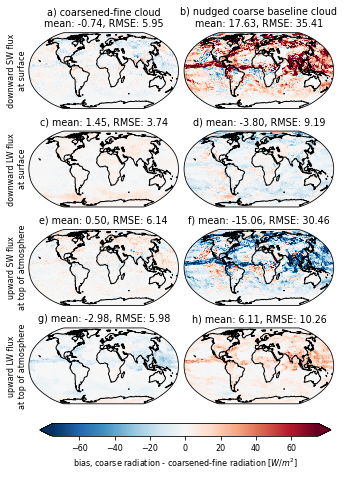

In [8]:
fig, axes, handles, _, fg = fv3viz.plot_cube(
    xr.merge([
        combined_biases, GRID
    ]),
    'combined_biases',
    row='variable_name',
    col='run',
    vmin=-75,
    vmax=75,
    colorbar=None,
    rasterized=True
)
# unfortunately xarray's facetgrid label plotting is hard to control so do it ourselves
fg.set_titles('')
for i, ax in enumerate(axes.flatten()):
    if i < 2:
        run_title = means.isel(panel=[i]).unstack().run.item() 
        full_title = (
            f"{ascii_lowercase[i]}) {run_title}"
            + f"\nmean: {means.isel(panel=i).item():0.2f}, RMSE: {rmses.isel(panel=i).item():0.2f}"
        )
    else:
        full_title = (
            f"{ascii_lowercase[i]}) mean: {means.isel(panel=i).item():0.2f}, RMSE: {rmses.isel(panel=i).item():0.2f}"
        )
    ax.set_title(full_title)
    if i % 2 == 0:
        variable_label = means.isel(panel=[i]).unstack().variable_name.item()
        ax.text(-0.08, 0.5, variable_label, transform=ax.transAxes, rotation='vertical', ha='center', va='center')
fig.subplots_adjust(bottom=0.08)
cb_ax = fig.add_axes([0.05, 0.03, 0.9, 0.03])
cbar = plt.colorbar(
    handles[0],
    cax=cb_ax,
    orientation='horizontal',
    extend="both",
    label=r'bias, coarse radiation - coarsened-fine radiation [$W/{m^2}$]'
)
fig.set_size_inches([4.5, 6])
fig.savefig(f'./{OUTDIR}/coarsened_fine_clouds_baseline_radiation.pdf', bbox_inches='tight')